In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [16]:
# Загрузка данных
train = pd.read_csv("Data/train.csv")
formula_train = pd.read_csv("Data/formula_train.csv")
test = pd.read_csv("Data/test.csv")
formula_test = pd.read_csv("Data/formula_test.csv")

In [17]:
# Предобработка данных
formula_train = formula_train.drop(columns=['critical_temp'])
train_full = pd.concat([train, formula_train], axis=1).drop(columns=['material'])
X = train_full.drop(columns=['critical_temp'])
y = train_full['critical_temp']

In [18]:
test_full = pd.concat([test, formula_test], axis=1).drop(columns=['material'])

In [19]:
# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(test_full)

In [20]:
# Разделение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Создание Dataset и DataLoader
class SuperconductorDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
train_dataset = SuperconductorDataset(X_train, y_train)
val_dataset = SuperconductorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [23]:
# Архитектура нейронной сети
class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)  # Без активации на последнем слое для регрессии
        return x

In [24]:
net = RegressionNet(X_train.shape[1])

# Определение функции потерь и оптимизатора
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Обучение модели
epochs = 100
train_losses, val_losses = [], []

In [25]:
for epoch in range(epochs):
    net.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs).squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Оценка на валидационной выборке
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = net(inputs).squeeze()
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch+1}/{epochs} - Training loss: {train_losses[-1]:.4f}, Validation loss: {val_losses[-1]:.4f}')

Epoch 1/100 - Training loss: 464.8994, Validation loss: 269.5169
Epoch 2/100 - Training loss: 236.8037, Validation loss: 225.2395
Epoch 3/100 - Training loss: 213.4297, Validation loss: 209.0927
Epoch 4/100 - Training loss: 203.9697, Validation loss: 208.4379
Epoch 5/100 - Training loss: 191.7869, Validation loss: 196.9702
Epoch 6/100 - Training loss: 185.6570, Validation loss: 226.9601
Epoch 7/100 - Training loss: 178.2264, Validation loss: 224.4730
Epoch 8/100 - Training loss: 173.6980, Validation loss: 183.0135
Epoch 9/100 - Training loss: 169.3491, Validation loss: 176.5976
Epoch 10/100 - Training loss: 163.0232, Validation loss: 178.4627
Epoch 11/100 - Training loss: 162.8715, Validation loss: 170.3828
Epoch 12/100 - Training loss: 157.0453, Validation loss: 174.9573
Epoch 13/100 - Training loss: 150.9178, Validation loss: 169.9028
Epoch 14/100 - Training loss: 148.3370, Validation loss: 180.8507
Epoch 15/100 - Training loss: 146.2978, Validation loss: 158.0874
Epoch 16/100 - Trai

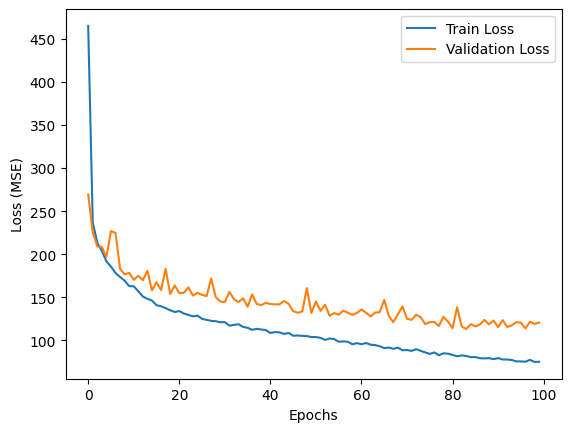

In [26]:
# Визуализация функции потерь
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [27]:
# Получение предсказаний для тестового набора
test_tensor = torch.tensor(X_test, dtype=torch.float32)
net.eval()
with torch.no_grad():
    y_pred_test = net(test_tensor).squeeze().numpy()

In [28]:
submission = pd.DataFrame({'index': range(len(y_pred_test)), 'critical_temp': y_pred_test})
submission.to_csv("result.csv", index=False)